importazione delle librerie necessarie per svolgere il progetto:

In [20]:
import pandas as pd
import networkx as nx
import pickle
from serpapi import GoogleScholarSearch
import matplotlib.pyplot as plt
from pyvis.network import Network

## Primo punto
1. A partire da nodes.csv, utilizzare la libreria Python SerpAPI per scaricare, per
ciascuno dei 7 autori elencati:
- author_id: ID identificativo del profilo Google Scholar
- cited_by: numero totale di citazioni ricevute
- interests: elenco degli interessi di ciascun autore
Sfruttando la libreria Python Pandas, usare la struttura dati DataFrame per
aggiornare il file originale con apposite colonne e memorizzarlo nella cartella
/data.

In [21]:
#creazione di un dataframe a partire da node.csv fornito
nodes_df = pd.read_csv("./data/nodes.csv")
display(nodes_df)

,Unnamed: 0,name,affiliations,author_id,cited_by,interests
0,0,David La Barbera,Università Degli Studi Di Udine,MvN8wKEAAAAJ,139,"[{'title': 'Computer Science', 'serpapi_link':..."
1,1,Michael Soprano,Postdoctoral Research Fellow at the University...,ocK0qRUAAAAJ,210,"[{'title': 'Computer Science', 'serpapi_link':..."
2,2,Kevin Roitero,University of Udine,1xd52jMAAAAJ,690,"[{'title': 'Artificial Intelligence', 'serpapi..."
3,3,Stefano Mizzaro,Full professor of Computer Science and Informa...,2wvJC6IAAAAJ,4739,"[{'title': 'Information retrieval', 'serpapi_l..."
4,4,Damiano Spina,"School of Computing Technologies, RMIT University",sLzYrNYAAAAJ,2483,"[{'title': 'Information Retrieval', 'serpapi_l..."
...,...,...,...,...,...,...
71,64,Claudiu S. Firan,Unknown affiliation,SRc8aowAAAAJ,1742,[]
72,65,Giorgio Brajnik,Associate Professor of User Centered Developme...,a-qHaRIAAAAJ,3585,"[{'title': 'Usability', 'link': 'https://schol..."
73,66,Pavlos Vougiouklis,Huawei Technologies,9J7YeR0AAAAJ,581,[]
74,67,Maarten de Rijke,University of Amsterdam & ICAI,AVDkgFIAAAAJ,36775,"[{'title': 'Information retrieval', 'link': 'h..."


Ricerca degli autori presenti nel dataframe utilizzando SerpAPI, i JSON di tutti gli autori vengono salvati dentro un array

In [ ]:
results = []
for index, row in nodes_df.iterrows():
    # Per trovare il json
    params = {
        "api_key": "...",       #inserire private key
        "engine": "google_scholar_profiles",
        "hl" : "en",
        "mauthors" : row['name'],
        "affilations" : row['affiliations']
    }
    search = GoogleScholarSearch(params)
    result = search.get_dict() #salva i risultati json come dizionario
    results.append(result) #array dei json
    

Ricerca dei dati richiesti per ogni autore per poi creare un dataframe con le colonne:
* author_id
* cited_by
* interests 

Il dataframe appena creato viene poi concatenato al dataframe 'nodes_df' creato in precedenza in modo da avere un dataframe che contiene tutti i dati di nostro interesse per ognuno dei 7 autori presenti in nodes.csv

In [ ]:
author_id = []
cited_by = []
interests = []

#request : richiesta API 
for request in results: 
    #profile: singolo profilo di ogni richiesta
    for profile in request['profiles']:
        #selezione del profilo profile corretto 
        for index, row in nodes_df.iterrows():
            if (profile['name'] == row['name'] and profile['affiliations'] == row['affiliations']):
                author_id.append(profile['author_id']) 
                cited_by.append(profile['cited_by'])
                interests.append(profile['interests']) 
                
filtered_results = pd.DataFrame({
    'author_id': author_id,
    'cited_by': cited_by,
    'interests':interests
    })

nodes_df = pd.concat([nodes_df,filtered_results], axis=1)
display(nodes_df)

### Aggiornamento del file originale nodes.csv
Sovrascrizione del file originale nodes.csv con l'aggiunta delle colonne author_id, cited_by e interests di nodes_df

In [ ]:
nodes_df.to_csv('./data/nodes.csv') #sovrascrivo il file vecchio con le nuove informazioni aggiunte

## Secondo punto
Per ciascuno dei 7 autori, utilizzare il suo ID per accedere al relativo profilo Google
Scholar e scaricare l’elenco dei suoi coautori, sempre via SerpAPI. Con tale elenco
di nomi: 
1. Utilizzare le SerpAPI per cercare su Google Scholar un ricercatore che
corrisponde a tale nome. Per ciascuno, salvare name, affiliations,
author_id, cited_by e interests in un nuovo DataFrame contenente tutte
queste informazioni relative ai coautori dei 7 autori originari.
2. Concatenare il DataFrame con i 7 autori originari e quello dei coautori
generato al punto 2a in un unico DataFrame.
NOTA BENE: è sufficiente effettuare la ricerca dei profili per nome, non
accedere al loro profilo tramite id.
ASSUNZIONE: in questo caso non potete identificare il profilo corretto tramite
il valore di affiliations, quindi assumete che quello corretto sia il primo
ritornato nella lista di authors.
3. Creare un terzo DataFrame con le colonne author1, author2 che
rappresenta le co-authorship. In tale DataFrame, una riga rappresenta un
arco di coauthorship tra due autori.
ESEMPIO: David La Barbera, Michael Soprano è una riga del DataFrame
creato al punto 2c se Michael Soprano è coautore di David La Barbera. La
co-authorship è binaria, non pesata.
A questo punto avrete prodotto due DataFrame:
- Uno per le informazioni relative agli autori (originali + i relativi coautori) e
contenente per ciascuno di essi i valori di name, affiliations, cited_by,
interests. Salvare come nodes.csv nella cartella /data tale DataFrame.
- Uno per le relazioni di co-authorship dai 7 autori principali verso i relativi
coautori con colonne author1, author2. Salvare come edges.csv nella
cartella /data tale DataFrame.


Richiesta a SerpApi per i profili degli autori di nodes_df

In [ ]:
results_authors = []
for index, row in nodes_df.iterrows():
    # Per trovare il json
    params = {
        "api_key": "...",       #inserire private key
        "engine": "google_scholar_author",
        "hl" : "en",
        "author_id" : row['author_id']
    }
    search = GoogleScholarSearch(params)
    result_author = search.get_dict() #salva i risultati json come dizionario
    results_authors.append(result_author) #array dei json
    
display(results_authors)


Ricerca dei coautori e filtraggio dei duplicati in quanto più autori possono aver lavorato con gli stessi co-autori. L'obbiettivo è ottenere una lista che contenga una sola volta tutti gli ID di ogni co_autore

In [ ]:
co_authors_id = []
for author in results_authors:
    for co_author in author['co_authors']:  
        co_authors_id.append(co_author['author_id'])
#fare un altro df nella quale teniamo per ogni autore i suoi coautori in modo da poter fare il grafo 

co_authors_id = list(set(co_authors_id)) #set rimuove i duplicati dall'array

display(co_authors_id)

Rimozione dei sette autori originali per poter avere dentro la lista solo i nuovi co_autori trovati

In [ ]:
#itero per ogni riga del datafre nodes_df
for index, row in nodes_df.iterrows():
    if row['author_id'] in co_authors_id:
        co_authors_id.remove(row['author_id'])

Richiesta a SerpApi per trovare le informazioni contenute nei profili di tutti i co-autori salvati in co_authors_id

In [ ]:
results_co_authors = []
for id in co_authors_id:
    # Per trovare il json
    params = {
        "api_key": "...",       #inserire private key
        "engine": "google_scholar_author",
        "hl" : "en",
        "author_id" : id
    }
    search = GoogleScholarSearch(params)
    result_co_author = search.get_dict() #salva i risultati json come dizionario
    results_co_authors.append(result_co_author) #array dei json
    

Dopo aver effettuato la ricerca si esegue il salvataggio di tutte le informazi relative ai co-autori dentro degli array per poi creare un dataframe "co_author_df" con le seguenti colonne:
* name
* affiliations
* author_id
* cited_by
* interets

In [16]:
author_id = []
cited_by = []
interests = []
name = []
affiliations = []

for fileJ in results_co_authors: 
    name.append(fileJ['author']['name'])
    affiliations.append(fileJ['author']['affiliations'])
    author_id.append(fileJ['search_parameters']['author_id']) 
    cited_by.append(fileJ['cited_by']['table'][0]['citations']['all'])
    interests = (*interests, (fileJ['author']['interests'])) if 'interests' in fileJ['author'] else (*interests, [] )

co_author_df = pd.DataFrame({
    'name' : name,
    'affiliations':affiliations,
    'author_id': author_id,
    'cited_by': cited_by,
    'interests':interests
})
display(co_author_df)

,name,affiliations,author_id,cited_by,interests
0,Dante Degl'Innocenti,Datamantix,Ay6L7NsAAAAJ,117,"[{'title': 'Artificial Intelligence', 'link': ..."
1,Arkaitz Zubiaga,Queen Mary University of London,IUb-xxMAAAAJ,6611,"[{'title': 'Social Media Mining', 'link': 'htt..."
2,Marco Pavan,"PhD in Computer Science, University of Udine",-UudVuUAAAAJ,112,"[{'title': 'Data Mining', 'link': 'https://sch..."
3,Ujwal Gadiraju,"Assistant Professor, Web Information Systems, ...",FX7BF6QAAAAJ,3263,"[{'title': 'Human-centered AI', 'link': 'https..."
4,Karl Aberer,Professor of Computer and Communication Scienc...,ifU81ikAAAAJ,23830,"[{'title': 'Social Media', 'link': 'https://sc..."
...,...,...,...,...,...
64,Claudiu S. Firan,Unknown affiliation,SRc8aowAAAAJ,1742,[]
65,Giorgio Brajnik,Associate Professor of User Centered Developme...,a-qHaRIAAAAJ,3585,"[{'title': 'Usability', 'link': 'https://schol..."
66,Pavlos Vougiouklis,Huawei Technologies,9J7YeR0AAAAJ,581,[]
67,Maarten de Rijke,University of Amsterdam & ICAI,AVDkgFIAAAAJ,36775,"[{'title': 'Information retrieval', 'link': 'h..."


Concatenazione del dataframe degli autori e dei co-autori:

In [26]:
final_node_df = pd.concat( [nodes_df, co_author_df]) #dataframe con tutti gli autori di nostro interesse
final_node_df = final_node_df.drop('Unnamed: 0', axis=1) #eliminazione della colonna indesiderata
display(final_node_df)

,name,affiliations,author_id,cited_by,interests
0,David La Barbera,Università Degli Studi Di Udine,MvN8wKEAAAAJ,139,"[{'title': 'Computer Science', 'serpapi_link':..."
1,Michael Soprano,Postdoctoral Research Fellow at the University...,ocK0qRUAAAAJ,210,"[{'title': 'Computer Science', 'serpapi_link':..."
2,Kevin Roitero,University of Udine,1xd52jMAAAAJ,690,"[{'title': 'Artificial Intelligence', 'serpapi..."
3,Stefano Mizzaro,Full professor of Computer Science and Informa...,2wvJC6IAAAAJ,4739,"[{'title': 'Information retrieval', 'serpapi_l..."
4,Damiano Spina,"School of Computing Technologies, RMIT University",sLzYrNYAAAAJ,2483,"[{'title': 'Information Retrieval', 'serpapi_l..."
...,...,...,...,...,...
64,Claudiu S. Firan,Unknown affiliation,SRc8aowAAAAJ,1742,[]
65,Giorgio Brajnik,Associate Professor of User Centered Developme...,a-qHaRIAAAAJ,3585,"[{'title': 'Usability', 'link': 'https://schol..."
66,Pavlos Vougiouklis,Huawei Technologies,9J7YeR0AAAAJ,581,[]
67,Maarten de Rijke,University of Amsterdam & ICAI,AVDkgFIAAAAJ,36775,"[{'title': 'Information retrieval', 'link': 'h..."


### Creazione del terzo dataframe: 
il dataframe contiene due colonne con i nomi degli autori (author_1, author_2) , su ogni riga si può osservare una coppia di autori che rappresenta una collaborazione per la creazione di un paper.

In [35]:
author_1 = []
author_2 = []
for original_author in results_authors:
    for co_author in original_author['co_authors']:
        author_1.append(original_author['author']['name'])
        author_2.append(co_author['name'])

edges_df = pd.DataFrame({
    'author_1': author_1,
    'author_2': author_2
})
display(edges_df)

,author_1,author_2
0,David La Barbera,Kevin Roitero
1,David La Barbera,Stefano Mizzaro
2,David La Barbera,Gianluca Demartini
3,David La Barbera,Damiano Spina
4,David La Barbera,Michael Soprano
...,...,...
122,Eddy Maddalena,Pavlos Vougiouklis
123,Eddy Maddalena,Jonathon Hare
124,Eddy Maddalena,Carlo Alberto Beltrami
125,Eddy Maddalena,Richard Gomer


### Eliminazione delle ridondanze di coautoraggio:
se gli autori principali hanno collaborato fra di loro, troveremo all'interno del dataframe due righe che identificano la loro collaborazione. E' necessario eliminare tali duplicati per mantenere solo un arco di co-autoraggio che li collega nel grafo.

In [ ]:
for index, row in edges_df.iterrows():
    to_remove = {'author_1': row['author_2'], 'author_2': row['author_1']}
    is_present = (edges_df == to_remove).all(axis=1).any()
    if is_present: edges_df = edges_df.drop(index)

Aggiornamento del file contenente gli autori di interesse con l'aggiunta dei 69 co-autori prima trovati:

In [85]:
final_node_df.to_csv('./data/nodes.csv')
edges_df.to_csv('./data/edges.csv')

Apertura dei file che contengono il dataframe degli autori e il dataframe che contiene i collegamenti di co-autoraggio tra essi:

In [27]:
final_node_df = pd.read_csv('./data/nodes.csv')
edges_df = pd.read_csv('./data/edges.csv')

### Terzo punto
Utilizzando i due DataFrame prodotti:
1. Generare un grafo indiretto che ne rappresenta le informazioni contenute.
Salvare (serializzare) il grafo in locale nella cartella /graphs .
2. Visualizzare il grafo prodotto colorando i nodi a seconda del loro grado con le
seguenti colorazioni: grigio per nodi con grado uguale a 1, blu per nodi con
grado compreso tra 2 e 10, viola per nodi con grado compreso tra 11 e 20,
giallo per nodi con grado maggiore di 20. Inoltre, per ciascun nodo
visualizzare il nome dell’autore. Salvare la visualizzazione nella cartella
/visualizations

Creazione del grafo indiretto 'author_graph' utilizzando i dataframe 'final_node_df' e 'edges_df': il grafo restituito è indiretto in quanto la relazione di co-autoraggio è bidirezionale.

In [28]:
author_graph = nx.Graph()

#aggiunta di un nodo per ogni autore presente in autorgraph iterando sulle righe del dataframe
for index, row in final_node_df.iterrows():
    author_graph.add_node(row['name'],
                          affiliations=row['affiliations'],
                          author_id =row['author_id'], 
                          cited_by=row['cited_by'], 
                          interests=row['interests'])

In [29]:
#aggiunta di un arco che collega author_1 ad author_2 per ogni riga di edge_df
for index, row in edges_df.iterrows():
    author_graph.add_edge(row['author_1'], row['author_2'])

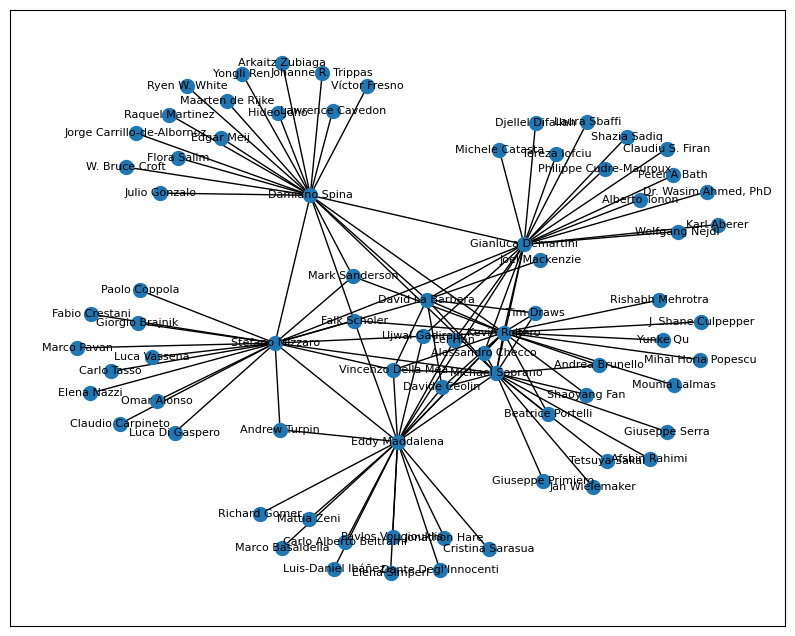

In [30]:
#creazione della rappresentazione grafica del grafo author_graph
plt.figure(figsize=(10,8))
nx.draw_networkx(author_graph,pos = nx.spring_layout(author_graph), node_size=100, font_size=8)

In [31]:
#salvataggio del grafo in gpickle
with open( './graphs/coauthorship_graph.gpickle', 'wb') as f:
    pickle.dump(author_graph, f)

In [32]:
#recuperare il grafo dal documento gpickle
with open( './graphs/coauthorship_graph.gpickle', 'rb') as f:
    coauthorship_graph = pickle.load(f)

Viene definita una funzione che permette di assegnare un colore e una dimensione ad ogni singolo nodo in base al proprio grado

In [33]:
#definisci stile grafo
def set_node_style(measures):
    colors = []
    sizes = []
    for measure in measures:
        if measure == 1:
            colors.append('gray')
            sizes.append(40)
        elif measure >= 2 and measure <= 10:
            colors.append('blue')
            sizes.append(80)
        elif measure >= 11 and measure <= 20:
            colors.append('purple')
            sizes.append(120)
        elif measure > 20:
            colors.append('yellow')
            sizes.append(200)
    style = {
        'colors' : colors,
        'sizes' : sizes
    }
    return style
        

Funzione che disegna il grafo :
* nodi:  viene utilizzata la funzione set_node_style per impostare colore e dimensione dei nodi
* archi: viene imposta una funzione che colora gli archi di rosso se l'attributo 'new' è presente tra gli attributi dell'arco, altrimenti rimangono neri.

Nota Bene: la funzione implementata per la corolazione degli archi verrà utilizzata in seguito nel quarto punto.

In [34]:
#definizione per disegnare grafi
def draw(graph, pos, measures, measure_name, path):
    nx.draw_networkx(graph, pos, node_size=set_node_style(measures)['sizes'], 
                        node_color=set_node_style(measures)['colors'],
                        edge_color=['red' if 'new' in data else 'black' for u, v, data in graph.edges(data=True)],
                        font_size=8)
    plt.title(measure_name)
    plt.axis('off')
    plt.savefig(path)
    plt.show()

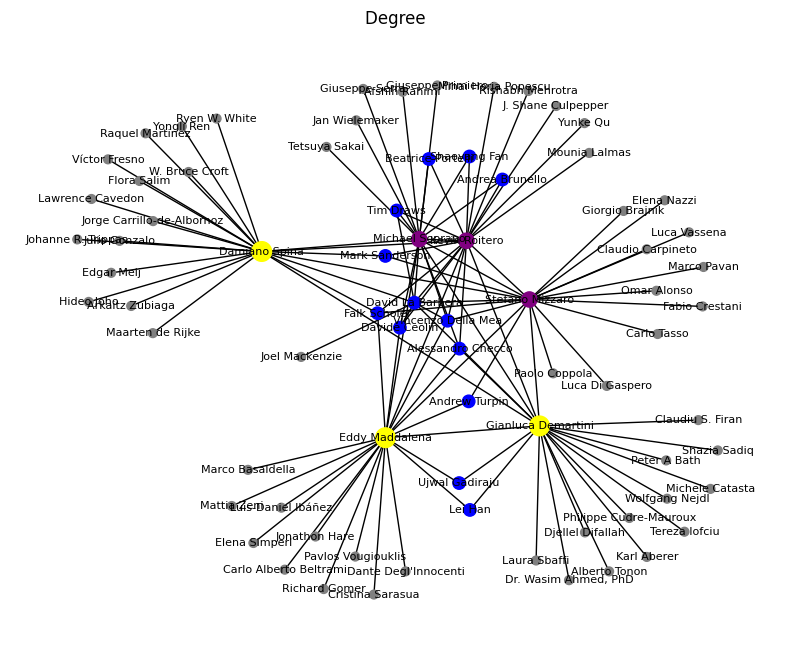

In [35]:
plt.figure(figsize=(10,8))
draw(
    author_graph,
    nx.spring_layout(author_graph),
    list(dict(author_graph.degree()).values()),
    'Degree ',
    "./visualizations/first_graph.pdf"
)

### Quarto punto
A partire dal grafo prodotto al punto 3:
1. Generarne un secondo dove il numero di nodi è lo stesso, mentre il numero di
archi è aumentato di 50 utilizzando la tecnica del Preferential Attachment.
Salvare il grafo in locale nella cartella /graphs.
2. Visualizzare e salvare il nuovo grafo come fatto al punto 3b.


In [36]:
#calcolo del preferential attachment e ordinamento del risultato per probabilità più alta
sorted_attachment_probabilities = sorted(list(nx.preferential_attachment(coauthorship_graph)), key = lambda x:x[2], reverse=True)
extended_coauthorship_graph = coauthorship_graph


Aggiunta dei 50 archi più probabili al grafo originale:

In [37]:
for u,v,p in sorted_attachment_probabilities[:50]:
    extended_coauthorship_graph.add_edge(u,v, new=True)

### Creazione della rappresentazione grafica del grafo compresivo dei nuovi archi : 
i 50 archi aggiunti con il preferential attachment sono colorati di rosso in modo da poter controllare che siano stati aggiunti correttamente.

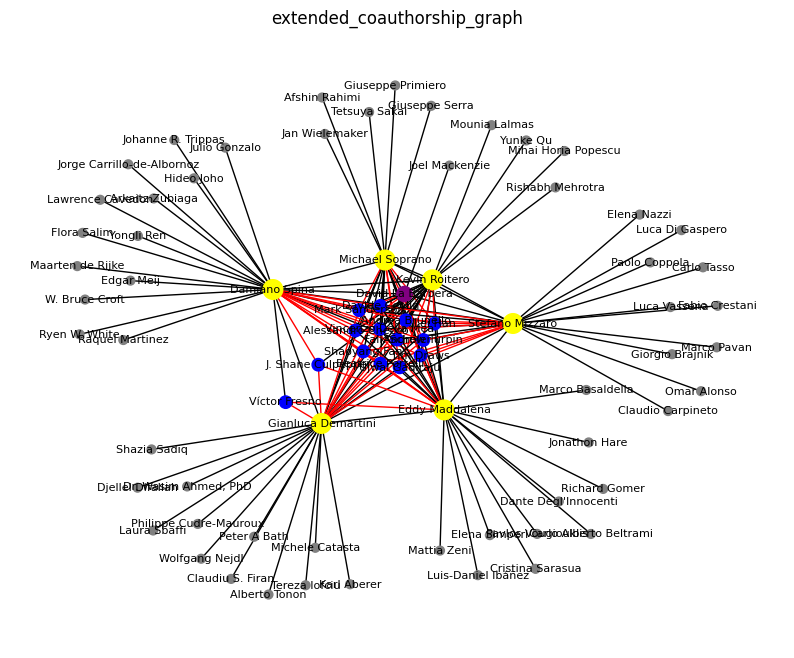

In [38]:
#plot del grafo extended_coauthorship_graph
plt.figure(figsize=(10,8))
draw(
    extended_coauthorship_graph,
    nx.spring_layout(extended_coauthorship_graph),
    list(dict(extended_coauthorship_graph.degree()).values()),
    'extended_coauthorship_graph',
    "./visualizations/extended_graph.pdf"
)

In [39]:
#salvataggio del grafo nel documento gpickle
with open( './graphs/extended_coauthorship_graph.gpickle', 'wb') as f:
    pickle.dump(extended_coauthorship_graph, f)

### Quinto punto
Per entrambi i grafi prodotti calcolare:
1. Coefficiente di clustering medio
2. Centro del grafo
3. Raggio
4. Distanza Media
5. Transitività
6. Coefficienti Omega e Sigma, per stimare la “small-world-ness”
7. Riassumere le informazioni in un DataFrame, dove ogni riga rappresenta le
informazioni relative ad un grafo, ed ogni colonna le informazioni relative ad
una misura calcolata per quel grafo. Salvare nella cartella /results tale
DataFrame.


In [40]:
names = ['original_graph', 'extended_graph']

#coefficiente di clustering medio:
cluster_coefficient = [nx.average_clustering(author_graph), nx.average_clustering(extended_coauthorship_graph)]

#centro del grafo
list_degree_centrality = nx.degree_centrality(author_graph).items()
list_degree_centrality_extended = nx.degree_centrality(extended_coauthorship_graph).items()
# Trovare l'autore con il valore massimo di degree centrality per ogni grafo e salvarlo in una lista
degree_centrality_original = max(list_degree_centrality, key = lambda x:x[1])[1]
degree_centrality_extended = max(list_degree_centrality_extended, key = lambda x:x[1])[1]

#cerchiamo se ci sono più autori che possiedono il valore massimo di degree,centrality e li inseriamo tutti in un array
max_degree_authors_original = []
for author, value in list(list_degree_centrality):
    if value == degree_centrality_original:
        max_degree_authors_original.append(author)

max_degree_authors_extended = []
for author, value in list(list_degree_centrality):
    if value == degree_centrality_original:
        max_degree_authors_extended.append(author)

max_degree_centrality =  [max_degree_authors_original, max_degree_authors_extended]
print(max_degree_centrality)

#Calcolare il raggio del grafo:
radius_original = nx.radius(author_graph)
radius_extended = nx.radius(extended_coauthorship_graph)
radius = [radius_original, radius_extended]

#distanza media tra nodi del grafo
average_distance_original = nx.average_shortest_path_length(author_graph)
average_distance_extended = nx.average_shortest_path_length(extended_coauthorship_graph)
average_distance = [average_distance_original, average_distance_extended]

#transitività
transitivity_original = nx.transitivity(author_graph)
transitivity_extended = nx.transitivity(extended_coauthorship_graph)
transitivity = [transitivity_original,transitivity_extended]


[['Damiano Spina', 'Gianluca Demartini', 'Eddy Maddalena'], ['Damiano Spina', 'Gianluca Demartini', 'Eddy Maddalena']]


In [41]:
#Coefficienti Omega, per stimare la “small-world-ness”
omega_original = nx.omega(author_graph)
omega_extended = nx.omega(extended_coauthorship_graph)

omega = [omega_original, omega_extended]
print(omega)


[-0.010346673579278542, 0.0027306861890946665]


In [42]:
#Coefficiente Sigma per stimare la "small-world-ness"
sigma_original = nx.sigma(author_graph)
sigma_extended = nx.sigma(extended_coauthorship_graph)

sigma = [sigma_original, sigma_extended]
print(sigma)

[0.9468065548076474, 0.9989730046948357]


Creazione del dataframe contenente le misurazioni sopra eseguite: sulle colonne avremo le varie misurazioni mentre sulle righe avremo i due grafi in modo da confrontarne i valori.

In [43]:
#creazione del dataframe delle misure
overall_measures = pd.DataFrame({
    'cluster_coefficient': cluster_coefficient,
    'graph_center':max_degree_centrality,
    'radius':radius,
    'average_distance':average_distance,
    'transitivity':transitivity,
    'omega_coefficients':omega,
    'sigma_coefficients':sigma
}, index=['author_graph', 'extended_coauthorship_graph'])
display(overall_measures)

,cluster_coefficient,graph_center,radius,average_distance,transitivity,omega_coefficients,sigma_coefficients
author_graph,0.167888,"[Damiano Spina, Gianluca Demartini, Eddy Madda...",2,2.647018,0.152542,-0.010347,0.946807
extended_coauthorship_graph,0.211240,"[Damiano Spina, Gianluca Demartini, Eddy Madda...",2,2.391579,0.294785,0.002731,0.998973


In [44]:
#salva i dati ottenuti in un .csv
overall_measures.to_csv('./results/overall_measures.csv')

### Sesto punto
Per entrambi i grafi prodotti calcolare per ogni nodo:
1. Degree Centrality
2. Betweenness Centrality
3. Closeness Centrality
4. Pagerank
5. HITS, per calcolare i valori di hubness e authority
6. Riassumere le due informazioni in un DataFrame per ciascun grafo, dove
ogni riga rappresenta le informazioni relative ad un nodo, ed ogni colonna le
informazioni relative ad una misura calcolata per quel nodo. Salvare nella
cartella /results tali DataFrame.


In [45]:
#degree centrality
authors_degree_centrality = (nx.degree_centrality(author_graph)) #dictionary
extended_coauthors_degree_centrality = (nx.degree_centrality(extended_coauthorship_graph))

#betweenness centrality
authors_betwenness_centrality = (nx.betweenness_centrality(author_graph))
extended_coauthors_betweenness_centrality = (nx.betweenness_centrality(extended_coauthorship_graph))

#closeness centrality
authors_closeness_centrality = (nx.closeness_centrality(author_graph))
extended_coauthors_closeness_centrality = (nx.closeness_centrality(extended_coauthorship_graph))

#page rank
authors_page_rank = (nx.pagerank(author_graph))
extended_coauthors_page_rank = (nx.pagerank(extended_coauthorship_graph))

#HITS
authors_HITS = (nx.hits(author_graph))
extended_coauthors_HITS = (nx.hits(extended_coauthorship_graph))


In [46]:
#creazione del primo dataframe riguardante i risultati di autor_graph
first_graph_centralities = pd.DataFrame({
    'degree_centrality': authors_degree_centrality.values(),
    'betwenness_centrality':authors_betwenness_centrality.values(),
    'closeness_centrality':authors_closeness_centrality.values(),
    'page_rank':authors_page_rank.values(),
    'HITS':authors_HITS[0].values()
}, index=authors_betwenness_centrality.keys())

display(first_graph_centralities)

,degree_centrality,betwenness_centrality,closeness_centrality,page_rank,HITS
David La Barbera,0.120000,0.038150,0.496689,0.033772,0.044330
Michael Soprano,0.240000,0.192511,0.568182,0.069315,0.061045
Kevin Roitero,0.266667,0.203640,0.576923,0.076233,0.066386
Stefano Mizzaro,0.266667,0.285225,0.576923,0.084028,0.058221
Damiano Spina,0.280000,0.345279,0.539568,0.095475,0.048800
...,...,...,...,...,...
Claudiu S. Firan,0.013333,0.000000,0.369458,0.005696,0.006487
Giorgio Brajnik,0.013333,0.000000,0.367647,0.005545,0.006880
Pavlos Vougiouklis,0.013333,0.000000,0.344037,0.005522,0.006406
Maarten de Rijke,0.013333,0.000000,0.352113,0.005837,0.005766


In [47]:
#creazione del secondo dataframe riguardanti i risultati di extended_coautorship_graph
extended_graph_centralities = pd.DataFrame({
    'degree_centrality': extended_coauthors_degree_centrality.values(),
    'betwenness_centrality':extended_coauthors_betweenness_centrality.values(),
    'closeness_centrality':extended_coauthors_closeness_centrality.values(),
    'page_rank':extended_coauthors_page_rank.values(),
    'HITS':extended_coauthors_HITS[0].values()
}, index=extended_coauthors_betweenness_centrality.keys())

display(extended_graph_centralities)

,degree_centrality,betwenness_centrality,closeness_centrality,page_rank,HITS
David La Barbera,0.173333,0.027439,0.547445,0.033868,0.041045
Michael Soprano,0.306667,0.134286,0.590551,0.062531,0.054002
Kevin Roitero,0.306667,0.111853,0.590551,0.061285,0.055035
Stefano Mizzaro,0.373333,0.255006,0.614754,0.082101,0.055634
Damiano Spina,0.440000,0.330352,0.641026,0.099371,0.059167
...,...,...,...,...,...
Claudiu S. Firan,0.013333,0.000000,0.390625,0.004504,0.004610
Giorgio Brajnik,0.013333,0.000000,0.382653,0.004466,0.004362
Pavlos Vougiouklis,0.013333,0.000000,0.386598,0.004443,0.004555
Maarten de Rijke,0.013333,0.000000,0.392670,0.004533,0.004639


In [48]:
#salvataggio dei due dataframe in un file .csv
first_graph_centralities.to_csv('./results/first_graph_centralities.csv')
extended_graph_centralities.to_csv('./results/extended_graph_centralities.csv')

### Settimo punto
Produrre una visualizzazione interattiva con PyVis dei due grafi con colorazioni di
nodi ed archi a piacimento. Salvare i due output in formato HTML nella cartella
/visualizations .

In [56]:
#funzione generale che permette la creazione e colorazione di un grafo interattivo (input: grafo, visualizzazione per pyvis)
def interactive_graph_visualization(graph, net):
    degree_dict = dict(graph.degree())

    for key,value in degree_dict.items():
        if value == 1:
            net.add_node(key, color='gray', size=4, title=graph.nodes[key]['affiliations'])
        elif value >= 2 and value <= 10:
            net.add_node(key, color='blue', size=8, title=graph.nodes[key]['affiliations'])
        elif value >= 11 and value <= 20:
            net.add_node(key, color='purple', size=12, title=graph.nodes[key]['affiliations'])
        elif value > 20:
            net.add_node(key, color='yellow', size=16, title=graph.nodes[key]['affiliations'])

    net.add_edges(graph.edges())

In [ ]:
#creazione del primo grzfo riguardante i risultati di autor_graph
net_first = Network(notebook=True,
                bgcolor="black",
                font_color="white"
                )
interactive_graph_visualization(author_graph, net_first)
net_first.show('./visualizations/interactive_first_graph.html')

In [ ]:
#creazione del secondo grafo riguardante i risultati di extended_coautorship_graph
net_extended = Network(notebook=True,
                bgcolor="black",
                font_color="white"
                )
interactive_graph_visualization(extended_coauthorship_graph, net_extended)
net_extended.show('./visualizations/interactive_extended_graph.html')